<a href="https://colab.research.google.com/github/HyezNee/3D/blob/Grag2021/Grag2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.5.4 

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import print_function
from __future__ import division

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T

import os
import pandas as pd
import numpy as np

import json
import csv
import cv2 # for image load

from PIL import Image

import albumentations as A
import albumentations.pytorch
import torchvision.transforms as transforms
from torch.utils.data import random_split

import timm

import random
import plotly.express as px # for grap
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from sklearn.metrics import f1_score # for f1 score

from tqdm import tqdm # for progress bar

# Get Dataset

In [5]:
# MY_DIR: 자기 이미지 압축파일 있는 경로 넣기
MY_DIR = '/content/drive/MyDrive/ML/DATA302/dataset'

FAKE_IMG_PATH = '/content/TestSet/'
REAL_IMG_PATH = '/content/REAL/'

In [6]:
os.system(f"unzip {MY_DIR}/TestSet.zip -d /content/")
!mkdir "tars"
os.system(f"tar -xvf {MY_DIR}/ILSVRC2012_img_train_t3.tar -C /content/tars")

!mkdir "REAL"
dir_list = os.listdir("/content/tars")
for dir in dir_list:
  os.system(f"tar -xvf /content/tars/{dir} -C /content/REAL")

In [7]:
# REAL 디렉토리 안에 아무것도 안뜨면 이 코드 한번 돌려보셈
os.listdir("/content/REAL")

['n02110185_2368.JPEG',
 'n02088466_8289.JPEG',
 'n02113799_4904.JPEG',
 'n02105162_8242.JPEG',
 'n02108422_3647.JPEG',
 'n02116738_1815.JPEG',
 'n02096051_161.JPEG',
 'n02111129_426.JPEG',
 'n02116738_9798.JPEG',
 'n02110627_3246.JPEG',
 'n02094258_439.JPEG',
 'n02100236_2132.JPEG',
 'n02098286_5080.JPEG',
 'n02095570_774.JPEG',
 'n02112018_5367.JPEG',
 'n02112350_1050.JPEG',
 'n02104029_4704.JPEG',
 'n02099601_3097.JPEG',
 'n02092002_120.JPEG',
 'n02111277_3056.JPEG',
 'n02112350_10079.JPEG',
 'n02096177_2703.JPEG',
 'n02113712_3315.JPEG',
 'n02108551_832.JPEG',
 'n02111500_3306.JPEG',
 'n02086240_1370.JPEG',
 'n02110806_18.JPEG',
 'n02093991_1684.JPEG',
 'n02099712_8014.JPEG',
 'n02111889_6343.JPEG',
 'n02106030_14653.JPEG',
 'n02088364_12440.JPEG',
 'n02088632_28.JPEG',
 'n02110806_1033.JPEG',
 'n02094433_923.JPEG',
 'n02086079_11511.JPEG',
 'n02093754_656.JPEG',
 'n02091467_6457.JPEG',
 'n02091831_4755.JPEG',
 'n02102177_575.JPEG',
 'n02113712_3289.JPEG',
 'n02100583_702.JPEG',
 '

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

random.seed(42)

model_list = {
    "convnext_base_in22ft1k" : {
        "model" : "convnext_base_in22ft1k", 
        "input_size" : (224, 224),
        "classifier_in_feature" : 1024
        }
}

optimizer_list = ["adam", "sgd"]

model_name = "convnext_base_in22ft1k"

CONFIG = {
    "batch_size" : 16,
    "epoch" : 200,
    "learning_rate" : 1e-4,
    "input_size" : model_list[model_name]["input_size"],
    "backbone" : model_list[model_name]["model"],
    "classifier_in_feature": model_list[model_name]["classifier_in_feature"],
    "device" : device,
    "patience" : 10,
    "optimizer" : optimizer_list[0],
    "input_norm_mean" : IMAGENET_DEFAULT_MEAN,
    "input_norm_std" : IMAGENET_DEFAULT_STD
}

batch_size = CONFIG["batch_size"]
epochs = CONFIG["epoch"]
learning_rate = CONFIG["learning_rate"]
input_size = CONFIG["input_size"]
backbone = CONFIG["backbone"]
classifier_in_feature = CONFIG["classifier_in_feature"]
device = CONFIG["device"]
patience = CONFIG["patience"]
optimizer = CONFIG["optimizer"]
input_norm_mean = CONFIG["input_norm_mean"]
input_norm_std = CONFIG["input_norm_std"]

Using cuda device


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size=16
input_size = (224, 224)
epoch = 200
learning_rate = 1e-4
patience = 10
optimizer = "adam"
input_norm_mean = IMAGENET_DEFAULT_MEAN
input_norm_std = IMAGENET_DEFAULT_STD

Using cuda device


# Read the Data

In [9]:
class CustomDataset(Dataset):
    def __init__(self, FAKE_path_label, REAL_path_label, input_size, transform=None, isTest=False):
        if isTest:
            self.FAKE_path_label = FAKE_path_label
            self.REAL_path_label = REAL_path_label
            self.input_size = input_size
            self.transform = transform
            self.isTest = isTest
            self.img_list = []

            for i in range(len(FAKE_path_label)):
                img_path = FAKE_path_label[i][0]
                image = Image.open(img_path)
                if self.transform:
                    image = self.transform(image=np.array(image))['image']
                self.img_list.append((image, 0))

            for i in range(len(REAL_path_label)):
                img_path = REAL_path_label[i][0]
                image = Image.open(img_path)
                if self.transform:
                    image = self.transform(image=np.array(image))['image']
                self.img_list.append((image, 1))
        else:
          # TODO
            pass

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image, label = self.img_list[idx]

        return image, label #label type: int

In [87]:
FAKE_path_label = []
REAL_path_label = []

# Get Fake Data
with open(os.path.join(FAKE_IMG_PATH, "operations.csv"), "r") as operations_csv:
    row = csv.reader(operations_csv, delimiter=',')
    for i, col in enumerate(row):
        if col[6] == "FALSE" and int(col[1]) >= 224: # col[6]: label, col[1]: cropsize
            FAKE_path_label.append((FAKE_IMG_PATH + col[0], 0)) # col[0]: src, 0 for false
# FAKE_path_label = FAKE_path_label[1:]
print(FAKE_path_label[0])
print(len(FAKE_path_label))

# Get Real Data
REAL_path_label = [(os.path.join(REAL_IMG_PATH, path), 1) for path in os.listdir(REAL_IMG_PATH)]
print(REAL_path_label[0])
print(len(REAL_path_label))

A_transform = A.Compose([
    A.PadIfNeeded(*input_size),
    albumentations.augmentations.crops.transforms.CenterCrop(*input_size),
    albumentations.augmentations.transforms.Normalize(
        mean=input_norm_mean, 
        std=input_norm_std
        ),
    albumentations.pytorch.transforms.ToTensorV2()
])

FAKE_path_label = random.sample(FAKE_path_label, k=1000)
REAL_path_label = random.sample(REAL_path_label, k=1000)

test_dataset = CustomDataset(FAKE_path_label, REAL_path_label, input_size=input_size, transform=A_transform, isTest=True)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

('/content/TestSet/biggan_256/biggan_002_230631.png', 0)
7960
('/content/REAL/n02110185_2368.JPEG', 1)
20580


# Model

In [11]:
# MODEL_DIR: model 폴더 위치
MODEL_DIR = '/content/drive/MyDrive/ML/DATA302/models'
os.system(f"cp -r {MODEL_DIR} /content/models")

0

In [12]:
# From https://github.com/grip-unina/DMimageDetection

def get_method_here(model_name, weights_path):
    if False:
        pass
    elif model_name == 'Grag2021_progan':
        model_name = 'Grag2021_progan'
        model_path = os.path.join(weights_path, model_name + '/model_epoch_best.pth')
        arch = 'res50stride1'
        norm_type = 'resnet'
        patch_size = None
    elif model_name == 'Grag2021_latent':
        model_name = 'Grag2021_latent'
        model_path = os.path.join(weights_path, model_name + '/model_epoch_best.pth')
        arch = 'res50stride1'
        norm_type = 'resnet'
        patch_size = None
    # else:
    #     print(model_name)
    #     from get_method import get_method
    #     model_name, model_path, arch, norm_type, patch_size = get_method(
    #         model_name)

    return model_name, model_path, arch, norm_type, patch_size


def def_model(arch, model_path, localize=False):
    import torch

    if arch == 'res50':
        # from networks.networks.resnet import resnet50
        model = resnet50(num_classes=1)
    elif arch == 'resnet18':
        from torchvision.models import resnet18
        model = resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 1)
    elif arch == 'res50stride1':
        import models.base_models.resnet_mod as resnet_mod
        model = resnet_mod.resnet50(num_classes=1, gap_size=1, stride0=1)
    else:
        print(arch)
        assert False

    assert localize is False

    if model_path == 'None':
        Warning('model_path is None! No weights loading in eval.py')
    else:
        dat = torch.load(model_path, map_location='cpu')
        if 'model' in dat:
            if ('module._conv_stem.weight' in dat['model']) or ('module.fc.fc1.weight' in dat['model']) or ('module.fc.weight' in dat['model']):
                model.load_state_dict(
                    {key[7:]: dat['model'][key] for key in dat['model']})
            else:
                model.load_state_dict(dat['model'])
        elif 'state_dict' in dat:
            model.load_state_dict(dat['state_dict'])
        elif 'net' in dat:
            model.load_state_dict(dat['net'])
        elif 'main.0.weight' in dat:
            model.load_state_dict(dat)
        elif '_fc.weight' in dat:
            model.load_state_dict(dat)
        elif 'conv1.weight' in dat:
            model.load_state_dict(dat)
        else:
            print(list(dat.keys()))
            assert False
    return model


In [31]:
models_list = {
    'Grag2021_progan': 'Grag2021_progan',
    'Grag2021_latent': 'Grag2021_latent'
}

model_name = 'Grag2021_progan'  # or 'Grag2021_latent'
_, model_path, arch, norm_type, patch_size = get_method_here(models_list[model_name], weights_path='/content/models/weights')

model = def_model(arch, model_path, localize=False)

In [32]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
# Grag2021에서는 안 씀!
'''
class Model(nn.Module):
    def __init__(self, backbone, classifier_in_feature, pretrained=True):
        super(Model, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.classifier = nn.Linear(
                in_features=classifier_in_feature,
                out_features=2
            )
        
        for param in self.backbone.parameters():
            param.requires_grad=False

    def forward(self, input):
        output = self.backbone(input) # bs 1 1000
        output = self.classifier(output)
        return output

model = Model(backbone, classifier_in_feature, pretrained=True)
'''
# model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

if optimizer == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
elif optimizer == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Test

In [98]:
@torch.no_grad()
def test_model(device, model, test_loader):
    pred_ans = []
    gt_ans = []
    corrects = 0

    model.eval()
    model = model.to(device)

    for x, gt in tqdm(test_loader):  # tqdm: progress bar 표시
        x, gt = x.to(device), gt.to(device)
        outputs = model(x)
        outputs = outputs.cpu().numpy()[:, 0]
        preds = np.mean(outputs, (1, 2))
        preds = torch.from_numpy(preds).to(device)
        preds = (preds < 0).float()
        # print(preds)
        # print(gt.data)
        # _, preds = torch.max(outputs, 1)

        pred_ans += preds.tolist()
        gt_ans += gt.tolist()
        corrects += torch.sum(preds == gt.data)

    # accuracy 출력
    print(f"total accuracy: {corrects / len(test_loader.dataset)}")

    return pred_ans, gt_ans


In [19]:
# confusion matrix 시각화
import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(label, pred, target_names=None, labels=True):
    cm = confusion_matrix(label, pred)
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


total accuracy: 0.7520000338554382


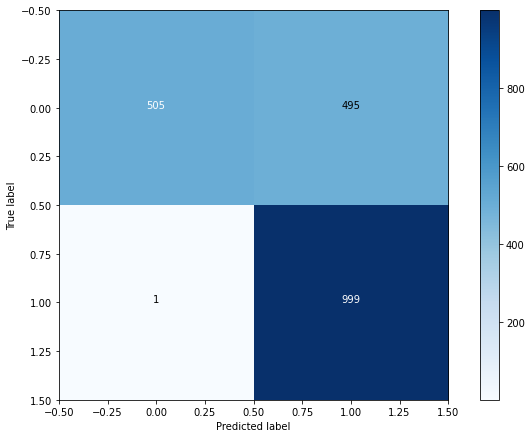

In [99]:
pred_ans, gt_ans = test_model(device, model, test_dataloader)
plot_confusion_matrix(gt_ans, pred_ans)

In [94]:
pred_ans[-100:]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
correct = [0,0,0,0] # 1,1 0,0 1,0 0,1

pred_ans = test_model(device, model, test_dataloader)

for (x, y) in pred_ans:
    if x == 1 and y == 1:
        correct[0] += 1
    elif x == 0 and y == 0:
        correct[1] += 1
    elif x == 1 and y == 0:
        correct[2] += 1
    elif x == 0 and y == 1:
        correct[3] += 1
    else:
        print(f"x:{x}, x type:{type(x)}, y:{y}, y type:{type(y)}")


print(pred_ans)
print(correct)

  0%|          | 0/125 [00:00<?, ?it/s]


TypeError: ignored